# 파이썬 머신러닝 완벽 가이드

# Credit Card Fraud Detection

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./Downloads/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [32]:
from sklearn.model_selection import train_test_split

#인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 반환
def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [33]:
def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    #stratify-y_target : y_target stratified으로 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [34]:
#평가를 한꺼번에 호출하는 함수
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}, F1:{:.4f}'.format(accuracy, precision, recall, f1))

In [35]:
#estimator 객체와 학습/테스트 데이터 세트를 받아 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

In [36]:
#로지스틱회귀를 통해 신용카드 사기 여부 예측
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   57    91]]
정확도:0.9992, 정밀도:0.8667, 재현율:0.6149, F1:0.7194


In [37]:
#conda install lightgbm

In [38]:
#LightGBM 모델
from lightgbm import LGBMClassifier
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도:0.9995, 정밀도:0.9573, 재현율:0.7568, F1:0.8453


## 데이터 정규화 후 모델 학습/예측/평가

- 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호

- Amount 피처는 신용카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다

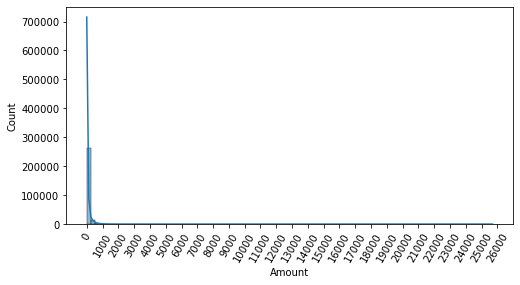

In [39]:
import seaborn as sns
plt.figure(figsize=(8, 4))
#rotation : 눈금 회전
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [40]:
#Amount를 표준 정규분포 형태로 변환한 뒤에 예측 성능 다시 측정
from sklearn.preprocessing import StandardScaler
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    #변환된 Amount를 Amount_Scaled로 피쳐명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    #기존 Time, Amount 피쳐 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [41]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   58    90]]
정확도:0.9992, 정밀도:0.8654, 재현율:0.6081, F1:0.7143
오차 행렬
[[85290     5]
 [   37   111]]
정확도:0.9995, 정밀도:0.9569, 재현율:0.7500, F1:0.8409


## 이상치 데이터 제거 후 모델 학습/예측/평가

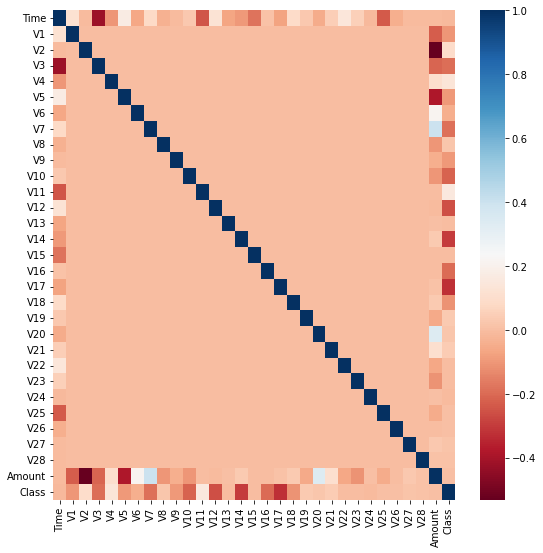

In [42]:
import seaborn as sns
plt.figure(figsize=(9, 9))
corr = card_df.corr()
#RdBu : 양의 상관관계 - 파랑, 음의 상관관계 -빨강
sns.heatmap(corr, cmap='RdBu');

In [43]:
#음의 상관관계는 V14, V17피쳐에서 높게 나타남
#V14, V17 이상치 확인
import numpy as np
def get_outlier(df, column):
    #fraud에 해당하는 column 데이터 추출
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * 1.5
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [44]:
outlier_index = get_outlier(df=card_df, column='V14')
outlier_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [45]:
outlier_index = get_outlier(df=card_df, column='V17')
outlier_index

Int64Index([], dtype='int64')

In [46]:
#get_preprocessed_df()를 로그 변환 후 V14 피쳐의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index = get_outlier(df=df_copy, column='V14')
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [47]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   48    98]]
정확도:0.9993, 정밀도:0.8750, 재현율:0.6712, F1:0.7597
오차 행렬
[[85290     5]
 [   25   121]]
정확도:0.9996, 정밀도:0.9603, 재현율:0.8288, F1:0.8897


## 오버 샘플링 적용 후 모델 학습/예측/평가

- 반드시 학습 데이터 세트만 오버 샘플링을 해야한다.

In [48]:
#conda install -c conda-forge imbalanced-learn.

In [49]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=0)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# lr_clf = LogisticRegression(max_iter=1000)
# get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

- 정밀도가 너무 작아짐

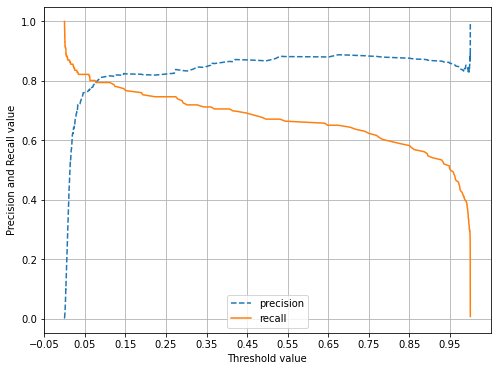

In [50]:
#precision : 정밀도 , recall : 재현율
#precision_recall_curve : 정밀도와 재현율의 임계값에 따른 값 변화를 시각화
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #precision_recall_curve(실제값 데이터 세트, 레이블 값이 1일 때의 예측 확률)
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])